In [1]:
%matplotlib inline

# Find the best model

Once the best cut for each model is identified, train each model on `data_training + data_validation` and test on `data_test`. This will define the **winning** model.

## `import` stuff

In [2]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import time
import matplotlib.pyplot as plt
import cPickle as pkl
import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from adenine.utils.extensions import Imputer
from sklearn.preprocessing import MinMaxScaler

# Predictive models
from palladio.wrappers import ElasticNetClassifier
from parsimony_sklearn import L1L2GLClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# GL stuff
import parsimony.functions.nesterov.gl as gl
import parsimony.algorithms as algorithms

## Load training & validation data

And merge them.

In [3]:
data_tr = pd.read_csv('../../dataset_03-2017/data_training.csv', header=0, index_col=0)
labels_tr = pd.read_csv('../../dataset_03-2017/labels_training.csv', header=0, index_col=0)
print('TR', data_tr.shape)

data_vld = pd.read_csv('../../dataset_03-2017/data_validation.csv', header=0, index_col=0)
labels_vld = pd.read_csv('../../dataset_03-2017/labels_validation.csv', header=0, index_col=0)
print('VLD', data_vld.shape)

data_trvld = pd.concat((data_tr, data_vld))
labels_trvld = pd.concat((labels_tr, labels_vld))
print('TRVLD', data_trvld.shape)

# Group questionnaires together
variables = data_tr.columns
# Get the first 3 letters: this will be the group ID
heads = np.array([v[:3] for v in variables])
# Group variables according the first letters of their name
groups = [(np.where(heads == tag)[0]).tolist() for tag in np.unique(heads)]
A = gl.linear_operator_from_groups(len(variables), groups)

# Make the 'SP' as the positive class
labels_trvld = np.where(labels_trvld.values.ravel() == 'SP', 1, -1)

('TR', (1853, 165))
('VLD', (398, 165))
('TRVLD', (2251, 165))


## Load test data

In [4]:
data_ts = pd.read_csv('../../dataset_03-2017/data_test.csv', header=0, index_col=0)
labels_ts = pd.read_csv('../../dataset_03-2017/labels_test.csv', header=0, index_col=0)
print('TS', data_ts.shape)

# Make the 'SP' as the positive class
labels_ts = np.where(labels_ts.values.ravel() == 'SP', 1, -1)

('TS', (448, 165))


## Build pipeline & define model parameter range

In [5]:
def build_pipeline(selected_model):
    """Build the MUCMD17 pipeline with the selected model."""
#    imp = Imputer(strategy='nn') # TODO: uncomment this and comment next
    imp = Imputer(strategy='mean')
    pp = MinMaxScaler(feature_range=(0, 1))
    clf = models[selected_model]['model']
    pipe = Pipeline([('imputing', imp),
                     ('preproc', pp),
                     ('classification', clf)])
    return pipe

def build_pipelineCV(selected_model):
    """Build the MUCMD17 pipeline with the selected model with param tuning via CV."""
    pipe = build_pipeline(selected_model)
    return GridSearchCV(pipe, param_grid=models[selected_model]['params'],
                        scoring='accuracy', n_jobs=-1,
                        cv=3, error_score=-np.inf)

models = {
          'ENET': {'model': ElasticNetClassifier(),
                   'params': {'classification__l1_ratio': np.linspace(0, 1, 10),
                              'classification__alpha': np.logspace(-5, 1, 10)}},
    
          'SLR': {'model': LogisticRegression(),
                   'params': {'classification__penalty': ['l1'],
                              'classification__C': np.logspace(-5, 1, 10)}},
    
#           'GL0': {'model': L1L2GLClassifier(),
#                  'params': {'classification__l2': [0.0],
#                             'classification__l1': np.logspace(-5, 1, 10),
#                             'classification__gl': np.logspace(-5, 1, 10),
#                             'classification__A': [A],
#                             'classification__algorithm': [algorithms.proximal.FISTA()],
#                             'classification__algorithm_params': [dict(max_iter=5000)]}},
    
          'SVM': {'model': SVC(),
                  'params': {'classification__kernel': ['linear'],
                             'classification__C': np.logspace(-3, 3, 10),
                             'classification__gamma': np.logspace(-5, 1, 10)}},
    
          'RF': {'model': RandomForestClassifier(),
                 'params': {'classification__max_features': [None, 'log2', 'sqrt', 0.5],
                            'classification__min_samples_leaf': map(int, np.linspace(5, 100, 10)),
                            'classification__oob_score': [True],
                            'classification__n_estimators': [1000]}},
    
          'GB': {'model': GradientBoostingClassifier(),
                 'params': {'classification__max_depth': map(int, np.linspace(50, 100, 10)),
                            'classification__max_features': [None, 'log2', 'sqrt', 0.5],
                            'classification__n_estimators': map(int, np.linspace(10, 200, 10)),
                            'classification__learning_rate': [0.05]}}
         }

## Get model signature

Load the model signature from the corresponding `txt` file and add it to the `models` dictionary.

In [7]:
for model in models.keys():
    ranking = pd.read_csv(os.path.join('selected_variables_wTOT', model+'_selected.csv'),
                          sep=',', index_col=0, header=0,
                          engine='python').index.tolist()
    models[model]['selected'] = ranking
    print(len(ranking))

105
39
30
32
32


## Models competition

Fit each model on its signature and measure the prediction scores on the test set.

In [8]:
def measure_scores(y_true, y_pred):
    acc = metrics.accuracy_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    rcll = metrics.recall_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    return acc, prec, rcll, f1

In [10]:
# Score containers
acc_dict = {}
prec_dict = {}
rcll_dict = {}
f1_dict = {}

for model in models:
    pipe = build_pipelineCV(model)
    selected = models[model]['selected']
    
    # Select the variables and build the training set
    X, y = data_trvld[selected].values, labels_trvld
    
    # Select the variables and build the test set
    X_ts, y_ts = data_ts[selected].values, labels_ts
    
#     # Fit the model
#     pipe.fit(X, y)
    
#     # Save it
#     with open(os.path.join('best_models', model+'_estimator.pkl'), 'wb') as dd:
#         pkl.dump(pipe, dd)
    
    # Load it
    with open(os.path.join('best_models_wTOT', model+'_estimator.pkl'), 'rb') as dd:
        pipe = pkl.load(dd)
    
        
    # Measure scores
    y_pred = pipe.predict(X_ts)
    acc_dict[model], prec_dict[model], rcll_dict[model], f1_dict[model] = measure_scores(y_ts, y_pred)
    print('{} acc: {} | prec: {} | rcll: {} | f1: {}'.format(model, acc_dict[model],
                                                             prec_dict[model], rcll_dict[model], f1_dict[model]))

ENET acc: 0.801339285714 | prec: 0.923423423423 | rcll: 0.740072202166 | f1: 0.821643286573
SVM acc: 0.796875 | prec: 0.922727272727 | rcll: 0.73285198556 | f1: 0.816901408451
RF acc: 0.852678571429 | prec: 0.916996047431 | rcll: 0.837545126354 | f1: 0.875471698113
SLR acc: 0.810267857143 | prec: 0.903361344538 | rcll: 0.776173285199 | f1: 0.834951456311
GB acc: 0.899553571429 | prec: 0.936090225564 | rcll: 0.898916967509 | f1: 0.917127071823


## Make plots

### Performance bar charts

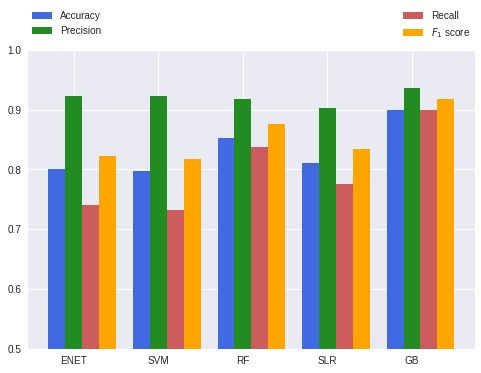

In [11]:
# plt.rcdefaults()

ind = np.arange(len(models.keys()))  # the x locations for the groups
width = 0.20      # the width of the bars

plt.bar(ind, [acc_dict[k] for k in acc_dict.keys()], width, label='Accuracy', color='royalblue')
plt.bar(ind+width, [prec_dict[k] for k in prec_dict.keys()], width, label='Precision', color='forestgreen')
plt.bar(ind+2*width, [rcll_dict[k] for k in rcll_dict.keys()], width, label='Recall', color='indianred')
plt.bar(ind+3*width, [f1_dict[k] for k in f1_dict.keys()], width, label=r'$F_1$ score', color='orange')
plt.xticks(ind+width, models.keys())
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([0.5, 1])
plt.savefig('final_scores_1.png')
plt.savefig('final_scores_1.pdf');

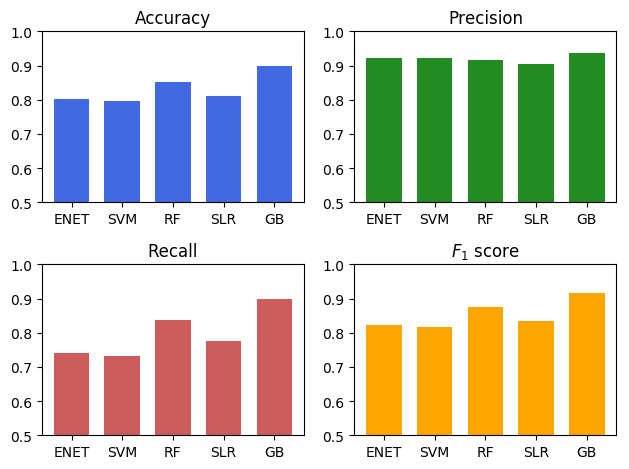

In [13]:
plt.rcdefaults()
width = 0.7

plt.subplot(221)
plt.title('Accuracy')
plt.bar(ind, [acc_dict[k] for k in acc_dict.keys()], width, color='royalblue')
plt.xticks(ind, models.keys())
plt.ylim([0.5, 1])

plt.subplot(222)
plt.title('Precision')
plt.bar(ind, [prec_dict[k] for k in prec_dict.keys()], width, color='forestgreen')
plt.xticks(ind, models.keys())
plt.ylim([0.5, 1])

plt.subplot(223)
plt.title('Recall')
plt.bar(ind, [rcll_dict[k] for k in rcll_dict.keys()], width, color='indianred')
plt.xticks(ind, models.keys())
plt.ylim([0.5, 1])

plt.subplot(224)
plt.title(r'$F_1$ score')
plt.bar(ind, [f1_dict[k] for k in f1_dict.keys()], width, color='orange')
plt.xticks(ind, models.keys())
plt.ylim([0.5, 1])

plt.tight_layout()

plt.savefig('final_scores_2.png')
plt.savefig('final_scores_2.pdf');

### Canberra distance heatmap

In [17]:
selected_list = []

for model in ['ENET', 'SLR', 'SVM', 'RF', 'GB']:#models.keys():
    selected = models[model]['selected']
    print(len(selected))
    selected_list.append(selected)

105
32
39
30
32


In [18]:
heatmap = np.empty((len(selected_list), len(selected_list)))
for i in range(len(selected_list)):
    for j in range(len(selected_list)):
        x = sum([data_tr.columns == k for k in selected_list[i]])
        y = sum([data_tr.columns == k for k in selected_list[j]])
        heatmap[i, j] = sp.spatial.distance.hamming(x, y)
print(heatmap)

[[ 0.          0.44242424  0.48484848  0.66060606  0.66060606]
 [ 0.44242424  0.          0.21212121  0.29090909  0.3030303 ]
 [ 0.48484848  0.21212121  0.          0.2969697   0.27272727]
 [ 0.66060606  0.29090909  0.2969697   0.          0.06060606]
 [ 0.66060606  0.3030303   0.27272727  0.06060606  0.        ]]


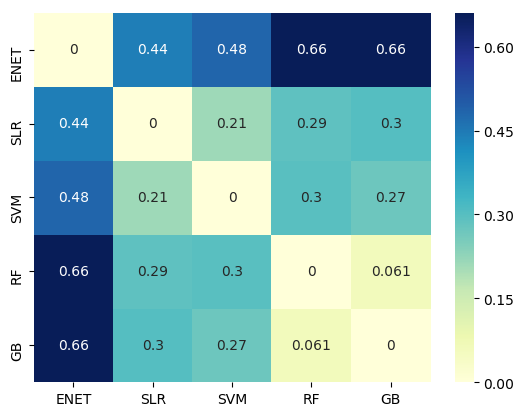

In [19]:
import seaborn as sns
plt.clf()
sns.heatmap(heatmap, annot=True, cmap="YlGnBu")
plt.xticks(0.5+np.arange(len(selected_list)), ['ENET', 'SLR', 'SVM', 'RF', 'GB'])
plt.yticks(0.5+np.arange(len(selected_list)), ['ENET', 'SLR', 'SVM', 'RF', 'GB'][::-1])
plt.savefig('selection_heatmap.png')
plt.savefig('selection_heatmap.pdf');